In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
plt.rcParams['font.size'] = 14
#import pylab_util as PU
import os

In [71]:
def data_to_float_array(data):
    mylist = data.split('\n')
    clean_list = mylist#[3:]
    clean_2 = list(filter(None,clean_list))
    
    start_ind = None
    
    for i, row in enumerate(clean_2):
        if row.find("1,") == 0:
            start_ind = i
    
    end_ind = None
    
    for i, row in enumerate(clean_2):
        if row.find("input") > -1:
            end_ind = i
            
    clean_3 = clean_2[start_ind:end_ind]
    nested_list = [row.split(',') for row in clean_3]
    str_array = np.array(nested_list)
    float_array = str_array.astype(float)
    return float_array
    #return str_array

In [45]:
import control
#import digcomp

In [46]:
import serial
import serial_utils

In [47]:
import importlib

In [107]:
importlib.reload(serial_utils)

<module 'serial_utils' from '/home/pi/SBR_git/serial_utils.py'>

In [116]:
portname = serial_utils.find_portname_RPi()
portname

'/dev/ttyACM4'

In [117]:
ser = serial_utils.serial_test(portname)

In [118]:
ser.open()

In [120]:
ser.print_all()

motor testing v. 1.0.0
input test case




In [121]:
ser.flush()

In [122]:
ser.write_char("c")

In [123]:
ser.print_all()

getting ready to calibrate
calibration results:
308 396 316 432 312 316 
2500 2500 2500 2500 2500 2500 

input test case




In [124]:
ser.write_char("1")
time.sleep(0.1)
data = ser.get_data()

In [125]:
data_array = data_to_float_array(data)

In [126]:
print(data)

#====================
kp=0.0500
#raw_loop_count,n_loop, t_ms, e, pwm1, pwm2, position
1,0.01,-1933,0,0,4933
2,5.04,-1933,0,0,4933
3,10.07,-1933,0,0,4933
4,15.15,-1933,0,0,4933
5,20.24,-1935,0,0,4935
6,25.33,-1933,0,0,4933
7,30.42,-1933,0,0,4933
8,35.52,-1933,0,0,4933
9,40.61,-1933,0,0,4933
10,45.69,-1935,0,0,4935
11,50.83,-1935,-96,0,4935
12,56.03,-1933,-96,0,4933
13,61.24,-1935,-96,0,4935
14,66.47,-1935,-96,0,4935
15,71.68,-1935,-96,0,4935
16,76.90,-1931,-96,0,4931
17,82.12,-1933,-96,0,4933
18,87.34,-1927,-96,0,4927
19,92.56,-1931,-96,0,4931
20,97.79,-1931,-96,0,4931
21,103.00,-1935,-96,0,4935
22,108.25,-1935,-96,0,4935
23,113.55,-1933,-96,0,4933
24,118.82,-1935,-96,0,4935
25,124.08,-1925,-96,0,4925
26,129.36,-1931,-96,0,4931
27,134.63,-1931,-96,0,4931
28,139.92,-1933,-96,0,4933
29,145.19,-1935,-96,0,4935
30,150.49,-1933,-96,0,4933
31,155.76,-1931,-96,0,4931
32,161.05,-1931,-96,0,4931
33,166.33,-1931,-96,0,4931
34,171.62,-1918,-95,0,4918
35,176.90,-1918,-95,0,4918
36,182.19,-1918,-95,

In [127]:
t_ms = data_array[:,1]
e = data_array[:,2]
pwm1 = data_array[:,3]
pwm2 = data_array[:,4]
pos = data_array[:,-1]
t = t_ms/1000

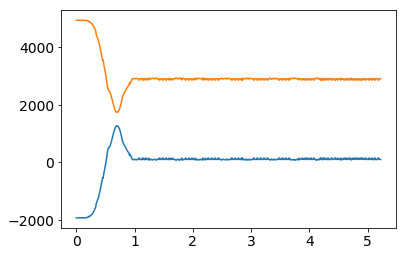

In [128]:
plt.figure()
plt.plot(t,e,t,pos)

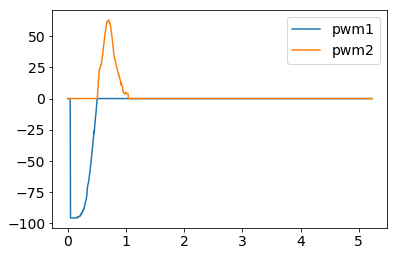

In [130]:
plt.figure()
plt.plot(t,pwm1,t,pwm2)
plt.legend(['pwm1','pwm2'])

In [80]:
ser.write_char("k")
ser.write_float(0.03)

In [81]:
ser.print_all()

kp = 0.0300
input test case


